<a href="https://colab.research.google.com/github/TAUforPython/Graph-MachineLearning/blob/main/example%20Gated%20Graph%20Attention%20Network.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
import torch
torch.__version__

'2.8.0+cu126'

In [3]:
# Install torch geometric
!pip install -q torch-scatter -f https://data.pyg.org/whl/torch-2.4.0+cu121.html
!pip install -q torch-sparse -f https://data.pyg.org/whl/torch-2.4.0+cu121.html
!pip install -q torch-geometric

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.9/10.9 MB 54.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.1/5.1 MB 57.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 63.7/63.7 kB 1.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 14.5 MB/s eta 0:00:00


In [9]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch_geometric.datasets import Planetoid
import torch_geometric.transforms as T
from torch_geometric.utils import to_dense_adj
import matplotlib.pyplot as plt
import numpy as np

# Check for GPU
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

# Install required packages
!pip install torch-geometric -q
!pip install torch-scatter torch-sparse torch-cluster torch-spline-conv -f https://data.pyg.org/whl/torch-2.0.0+cu118.html -q

Using device: cpu


GATED GRAPH ATTENTION NETWORK - FIXED DIMENSIONS
Dataset: 2708 nodes, 1433 features
Adjacency matrix: torch.Size([2708, 2708])
Features shape: torch.Size([1, 2708, 1433])

Training Info:
  Classes: 7
  Training nodes: 140
  Validation nodes: 500
  Test nodes: 1000

Model Architecture:
  Input features: 1433
  Hidden features: 64
  Output classes: 7
  Number of layers: 2
  Number of heads: 4

Starting training...
Epoch: 000, Loss: 2.2723, Train: 0.1571, Val: 0.1180, Test: 0.1050

=== FINAL RESULTS ===
Train Accuracy: 0.9857
Val Accuracy: 0.3880
Test Accuracy: 0.3920
Best Val Accuracy: 0.1180


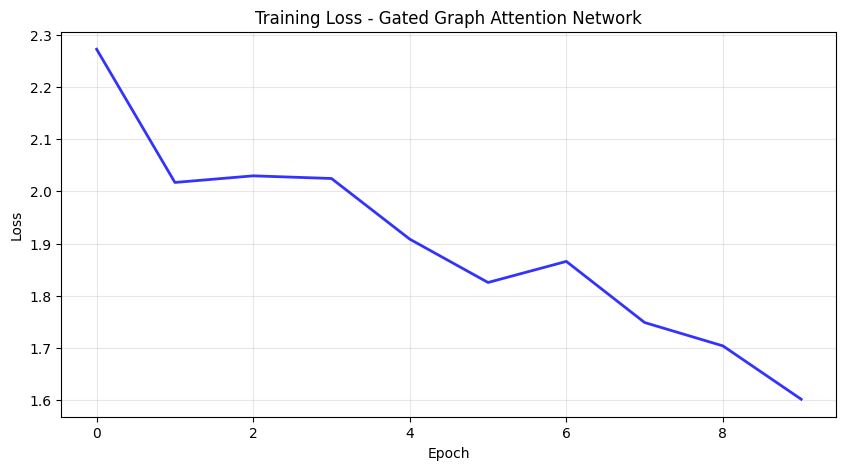


Final weights debug:
  List of 2 attention tensors
  Layer 0: shape torch.Size([1, 4, 2708, 2708]), dim 4
  Layer 1: shape torch.Size([1, 4, 2708, 2708]), dim 4

ATTENTION VISUALIZATION

Visualizing attention for node 0, layer 0, head 0:
Attention tensor shape: torch.Size([1, 4, 2708, 2708])
Attention tensor dimensions: 4


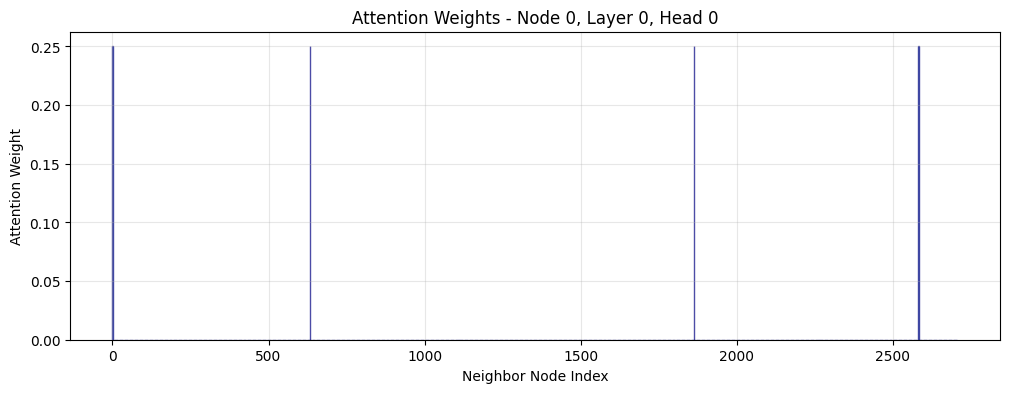

Top 5 attended neighbors for node 0:
  1. Node 1862: 0.2500
  2. Node 2582: 0.2500
  3. Node    0: 0.2500
  4. Node  633: 0.2500
  5. Node    3: 0.0000

Visualizing attention for node 10, layer 0, head 1:
Attention tensor shape: torch.Size([1, 4, 2708, 2708])
Attention tensor dimensions: 4


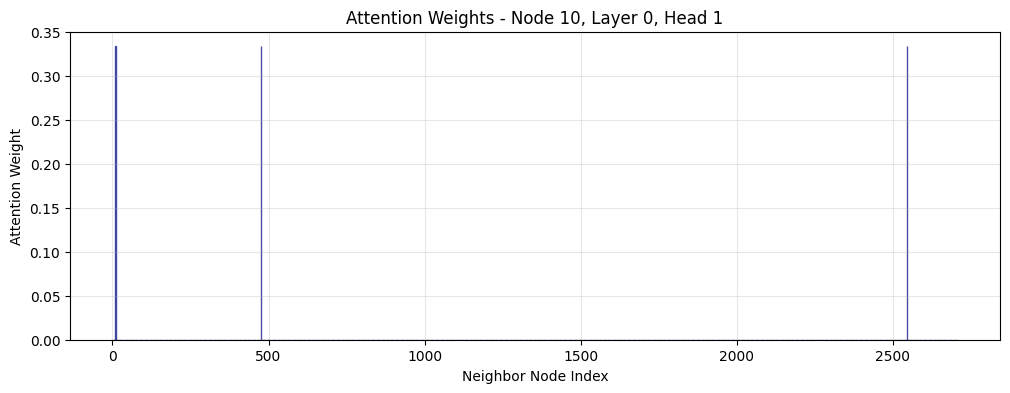

Top 5 attended neighbors for node 10:
  1. Node   10: 0.3334
  2. Node  476: 0.3333
  3. Node 2545: 0.3333
  4. Node    3: 0.0000
  5. Node    1: 0.0000

Visualizing attention for node 50, layer 1, head 0:
Attention tensor shape: torch.Size([1, 4, 2708, 2708])
Attention tensor dimensions: 4


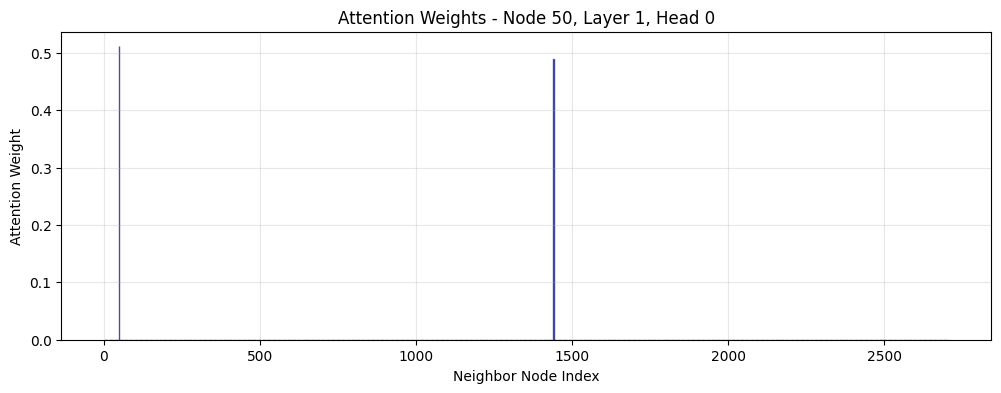

Top 5 attended neighbors for node 50:
  1. Node   50: 0.5110
  2. Node 1441: 0.4890
  3. Node    3: 0.0000
  4. Node    1: 0.0000
  5. Node    4: 0.0000

MODEL SUMMARY
Total parameters: 175,303
Trainable parameters: 175,303

Training completed successfully!


In [12]:

class GatedGraphAttentionLayer(nn.Module):
    def __init__(self, in_features, out_features, n_heads=4, dropout=0.4):
        super(GatedGraphAttentionLayer, self).__init__()

        self.in_features = in_features
        self.out_features = out_features
        self.n_heads = n_heads
        self.head_dim = out_features // n_heads

        assert out_features % n_heads == 0, "out_features must be divisible by n_heads"

        # Linear transformations for attention
        self.q_proj = nn.Linear(in_features, out_features)
        self.k_proj = nn.Linear(in_features, out_features)
        self.v_proj = nn.Linear(in_features, out_features)

        # Gating mechanism - fixed dimensions
        self.reset_gate = nn.Linear(in_features + out_features, out_features)
        self.update_gate = nn.Linear(in_features + out_features, out_features)
        self.candidate_proj = nn.Linear(in_features + out_features, out_features)

        # Output projection
        self.output_proj = nn.Linear(out_features, out_features)

        # Normalization and dropout
        self.layer_norm = nn.LayerNorm(out_features)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x, adj_mask):
        batch_size, num_nodes, in_features = x.shape

        # 1. MULTI-HEAD ATTENTION
        # Linear projections
        Q = self.q_proj(x)  # [batch_size, num_nodes, out_features]
        K = self.k_proj(x)  # [batch_size, num_nodes, out_features]
        V = self.v_proj(x)  # [batch_size, num_nodes, out_features]

        # Reshape for multi-head attention
        Q = Q.view(batch_size, num_nodes, self.n_heads, self.head_dim).transpose(1, 2)
        K = K.view(batch_size, num_nodes, self.n_heads, self.head_dim).transpose(1, 2)
        V = V.view(batch_size, num_nodes, self.n_heads, self.head_dim).transpose(1, 2)

        # Compute attention scores
        scale = np.sqrt(self.head_dim)
        attn_scores = torch.matmul(Q, K.transpose(-2, -1)) / scale

        # Apply adjacency mask
        if adj_mask.dim() == 3:
            adj_mask_expanded = adj_mask.unsqueeze(1)  # [batch_size, 1, num_nodes, num_nodes]
        else:
            adj_mask_expanded = adj_mask

        # Expand mask to match number of heads
        if adj_mask_expanded.size(1) == 1 and self.n_heads > 1:
            adj_mask_expanded = adj_mask_expanded.repeat(1, self.n_heads, 1, 1)

        # Apply mask to attention scores
        attn_scores = attn_scores.masked_fill(adj_mask_expanded == 0, -1e9)

        # Compute attention weights
        attn_weights = F.softmax(attn_scores, dim=-1)
        attn_weights = self.dropout(attn_weights)

        # Apply attention to values
        attended = torch.matmul(attn_weights, V)  # [batch_size, n_heads, num_nodes, head_dim]

        # Combine heads
        attended = attended.transpose(1, 2).contiguous()
        attended = attended.view(batch_size, num_nodes, self.out_features)

        # 2. GATING MECHANISM
        # Concatenate original features with attended features
        combined = torch.cat([x, attended], dim=-1)  # [batch_size, num_nodes, in_features + out_features]

        # Reset gate
        reset = torch.sigmoid(self.reset_gate(combined))

        # Update gate
        update = torch.sigmoid(self.update_gate(combined))

        # Candidate activation with reset gate applied to attended features
        reset_combined = torch.cat([x, reset * attended], dim=-1)
        candidate = torch.tanh(self.candidate_proj(reset_combined))

        # Final gated output
        output = (1 - update) * x + update * candidate

        # Handle dimension mismatch for residual connection
        if self.in_features != self.out_features:
            # Project input to match output dimension
            x_projected = F.linear(x,
                                 torch.eye(self.out_features, self.in_features).to(x.device))
            output = output + x_projected
        else:
            output = output + x

        # Layer normalization and activation
        output = self.layer_norm(output)
        output = F.elu(output)
        output = self.dropout(output)

        return output, attn_weights

#######################################
### FIXED GATED GRAPH ATTENTION NETWORK ###
#######################################

class GatedGAT(nn.Module):
    def __init__(self, n_feat, n_hidden, n_class, n_layers=2, n_heads=4, dropout=0.4):
        super(GatedGAT, self).__init__()

        self.n_layers = n_layers
        self.n_hidden = n_hidden

        # Input projection - ensure output matches n_hidden
        self.input_proj = nn.Linear(n_feat, n_hidden)

        # Gated attention layers - all use n_hidden for both input and output
        self.gat_layers = nn.ModuleList()
        for i in range(n_layers):
            self.gat_layers.append(
                GatedGraphAttentionLayer(n_hidden, n_hidden, n_heads, dropout)
            )

        # Output projection
        self.output_proj = nn.Linear(n_hidden, n_class)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x, adj_mask):
        # Store attention weights for all layers
        all_attention_weights = []

        # Input projection
        x = F.elu(self.input_proj(x))
        x = self.dropout(x)

        # Pass through gated attention layers
        for layer in self.gat_layers:
            x, attn_weights = layer(x, adj_mask)
            all_attention_weights.append(attn_weights)

        # Output projection
        x = self.output_proj(x)

        return F.log_softmax(x, dim=-1), all_attention_weights

#######################################
### DATA LOADING & UTILITIES        ###
#######################################

def load_cora_data():
    """Load and preprocess Cora dataset"""
    dataset = Planetoid(root='/tmp/Cora', name='Cora', transform=T.NormalizeFeatures())
    data = dataset[0]

    data = data.to(device)

    # Convert to dense adjacency matrix
    edge_index = data.edge_index
    adj = to_dense_adj(edge_index, max_num_nodes=data.num_nodes).squeeze(0)

    # Add self-loops
    adj = adj + torch.eye(adj.size(0)).to(device)

    features = data.x.unsqueeze(0)  # Add batch dimension [1, num_nodes, num_features]
    labels = data.y
    train_mask = data.train_mask
    val_mask = data.val_mask
    test_mask = data.test_mask

    print(f"Dataset: {features.shape[1]} nodes, {features.shape[2]} features")
    print(f"Adjacency matrix: {adj.shape}")
    print(f"Features shape: {features.shape}")

    return features, adj, labels, train_mask, val_mask, test_mask, dataset.num_classes

def debug_attention_weights(attention_weights, layer_name="Attention"):
    """Debug function to inspect attention weights dimensions"""
    print(f"\n{layer_name} weights debug:")
    if attention_weights is None:
        print("  No attention weights")
        return

    if isinstance(attention_weights, list):
        print(f"  List of {len(attention_weights)} attention tensors")
        for i, attn in enumerate(attention_weights):
            if attn is not None:
                print(f"  Layer {i}: shape {attn.shape}, dim {attn.dim()}")
            else:
                print(f"  Layer {i}: None")
    else:
        print(f"  Single tensor: shape {attention_weights.shape}, dim {attention_weights.dim()}")

def visualize_attention_safe(attention_weights, node_idx=0, layer_idx=0, head_idx=0):
    """Safe visualization that handles various tensor dimensions"""
    print(f"\nVisualizing attention for node {node_idx}, layer {layer_idx}, head {head_idx}:")

    if attention_weights is None:
        print("No attention weights to visualize")
        return

    # Handle list of attention weights
    if isinstance(attention_weights, list):
        if layer_idx >= len(attention_weights):
            print(f"Layer {layer_idx} not available. Max layer: {len(attention_weights)-1}")
            return
        attn_tensor = attention_weights[layer_idx]
    else:
        attn_tensor = attention_weights

    if attn_tensor is None:
        print("Attention tensor is None")
        return

    print(f"Attention tensor shape: {attn_tensor.shape}")
    print(f"Attention tensor dimensions: {attn_tensor.dim()}")

    # Handle different tensor dimensions
    try:
        if attn_tensor.dim() == 4:
            # Expected: [batch_size, n_heads, num_nodes, num_nodes]
            if head_idx >= attn_tensor.size(1):
                print(f"Head {head_idx} not available. Available heads: 0-{attn_tensor.size(1)-1}")
                return
            if node_idx >= attn_tensor.size(2):
                print(f"Node {node_idx} not available. Available nodes: 0-{attn_tensor.size(2)-1}")
                return

            attn_vals = attn_tensor[0, head_idx, node_idx, :].cpu().detach().numpy()

        elif attn_tensor.dim() == 5:
            # Handle 5D tensor: [batch_size, something, n_heads, num_nodes, num_nodes]
            print("5D tensor detected - attempting to extract...")
            if head_idx >= attn_tensor.size(2):
                print(f"Head {head_idx} not available. Available heads: 0-{attn_tensor.size(2)-1}")
                return
            if node_idx >= attn_tensor.size(3):
                print(f"Node {node_idx} not available. Available nodes: 0-{attn_tensor.size(3)-1}")
                return

            attn_vals = attn_tensor[0, 0, head_idx, node_idx, :].cpu().detach().numpy()

        else:
            print(f"Unexpected tensor dimension: {attn_tensor.dim()}. Cannot visualize.")
            return

        # Visualization
        plt.figure(figsize=(12, 4))
        plt.bar(range(len(attn_vals)), attn_vals, alpha=0.7, color='skyblue', edgecolor='navy')
        plt.title(f'Attention Weights - Node {node_idx}, Layer {layer_idx}, Head {head_idx}')
        plt.xlabel('Neighbor Node Index')
        plt.ylabel('Attention Weight')
        plt.grid(True, alpha=0.3)
        plt.show()

        # Print top neighbors
        if attn_tensor.dim() == 4:
            topk_vals, topk_indices = torch.topk(attn_tensor[0, head_idx, node_idx, :],
                                            min(5, len(attn_vals)))
        else:
            topk_vals, topk_indices = torch.topk(attn_tensor[0, 0, head_idx, node_idx, :],
                                            min(5, len(attn_vals)))

        print(f"Top 5 attended neighbors for node {node_idx}:")
        for i, (idx, val) in enumerate(zip(topk_indices.cpu(), topk_vals.cpu())):
            print(f"  {i+1}. Node {idx.item():4d}: {val.item():.4f}")

    except Exception as e:
        print(f"Error during visualization: {e}")

#######################################
### TRAINING FUNCTION               ###
#######################################

def train_gated_gat():
    # Load data
    features, adj, labels, train_mask, val_mask, test_mask, num_classes = load_cora_data()

    print(f"\nTraining Info:")
    print(f"  Classes: {num_classes}")
    print(f"  Training nodes: {train_mask.sum().item()}")
    print(f"  Validation nodes: {val_mask.sum().item()}")
    print(f"  Test nodes: {test_mask.sum().item()}")

    # Prepare adjacency mask (convert to float and add batch dimension)
    adj_mask = adj.unsqueeze(0).float()  # [1, num_nodes, num_nodes]

    # Initialize model with proper dimensions
    model = GatedGAT(
        n_feat=features.shape[2],  # 1433 for Cora
        n_hidden=64,               # Must be divisible by n_heads
        n_class=num_classes,       # 7 for Cora
        n_layers=2,
        n_heads=4,                 # 64/4 = 16 per head
        dropout=0.5
    ).to(device)

    # Print model architecture
    print(f"\nModel Architecture:")
    print(f"  Input features: {features.shape[2]}")
    print(f"  Hidden features: 64")
    print(f"  Output classes: {num_classes}")
    print(f"  Number of layers: 2")
    print(f"  Number of heads: 4")

    optimizer = optim.Adam(model.parameters(), lr=0.005, weight_decay=5e-4)

    def compute_accuracy(output, labels, mask):
        pred = output[mask].max(1)[1]
        acc = pred.eq(labels[mask]).sum().item() / mask.sum().item()
        return acc

    def train_epoch():
        model.train()
        optimizer.zero_grad()
        output, _ = model(features, adj_mask)
        loss = F.nll_loss(output[0][train_mask], labels[train_mask])
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
        optimizer.step()
        return loss.item()

    def evaluate():
        model.eval()
        with torch.no_grad():
            output, attention_weights = model(features, adj_mask)
            logits = output[0]

        train_acc = compute_accuracy(logits, labels, train_mask)
        val_acc = compute_accuracy(logits, labels, val_mask)
        test_acc = compute_accuracy(logits, labels, test_mask)

        return train_acc, val_acc, test_acc, attention_weights

    print("\nStarting training...")
    train_losses = []
    best_val_acc = 0
    best_attention_weights = None

    for epoch in range(10):
        loss = train_epoch()
        train_losses.append(loss)

        if epoch % 10 == 0:
            train_acc, val_acc, test_acc, attn_weights = evaluate()
            print(f'Epoch: {epoch:03d}, Loss: {loss:.4f}, '
                  f'Train: {train_acc:.4f}, Val: {val_acc:.4f}, Test: {test_acc:.4f}')

            if val_acc > best_val_acc:
                best_val_acc = val_acc
                best_attention_weights = attn_weights

    # Final evaluation
    train_acc, val_acc, test_acc, attn_weights = evaluate()
    print(f'\n=== FINAL RESULTS ===')
    print(f'Train Accuracy: {train_acc:.4f}')
    print(f'Val Accuracy: {val_acc:.4f}')
    print(f'Test Accuracy: {test_acc:.4f}')
    print(f'Best Val Accuracy: {best_val_acc:.4f}')

    return model, train_losses, best_attention_weights

#######################################
### MAIN EXECUTION                  ###
#######################################

# Run the training
print("=" * 60)
print("GATED GRAPH ATTENTION NETWORK - FIXED DIMENSIONS")
print("=" * 60)

try:
    model, losses, attention_weights = train_gated_gat()

    # Plot training loss
    plt.figure(figsize=(10, 5))
    plt.plot(losses, 'b-', linewidth=2, alpha=0.8)
    plt.title('Training Loss - Gated Graph Attention Network')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.grid(True, alpha=0.3)
    plt.show()

    # Debug attention weights
    debug_attention_weights(attention_weights, "Final")

    # Visualize attention weights with proper dimension handling
    if attention_weights is not None:
        print("\n" + "=" * 50)
        print("ATTENTION VISUALIZATION")
        print("=" * 50)

        # Try different visualization approaches
        visualize_attention_safe(attention_weights, node_idx=0, layer_idx=0, head_idx=0)
        visualize_attention_safe(attention_weights, node_idx=10, layer_idx=0, head_idx=1)
        visualize_attention_safe(attention_weights, node_idx=50, layer_idx=1, head_idx=0)

    # Model summary
    print(f"\n" + "=" * 50)
    print("MODEL SUMMARY")
    print("=" * 50)
    total_params = sum(p.numel() for p in model.parameters())
    trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
    print(f"Total parameters: {total_params:,}")
    print(f"Trainable parameters: {trainable_params:,}")

    print(f"\nTraining completed successfully!")

except Exception as e:
    print(f"Error during training: {e}")
    import traceback
    traceback.print_exc()